
# Law Replication: Densities of H2-Air Mixtures

This Code tries to calculate and compare the Densities of Hydrogen-Air Mixtures. \
We obtain the these from:
1. Using Canteras gri-mech gas object (ideal-gas approximation)
2. Using the Van-der-Waals EOS (non-ideal prediction)
4. CoolProps Backends (should be most accurate)
5. Reference values from Liang, Chung K. Law et al's paper (https://doi.org/10.1016/j.proci.2018.06.070, Fig.4). WebPlotDigitizer (https://apps.automeris.io/wpd4/) was used to extract the data and save it in a provided csv file (see subfolder /Extracted Plots)

Sources: \
Burke Mechanism: https://burke.me.columbia.edu/sites/burke.me.columbia.edu/files/content/chem_cti.txt \
Cantera Critical State Properties: https://cantera.org/stable/examples/python/thermo/critical_properties.html \
Coolprop Cubic EOS: http://www.coolprop.org/coolprop/Cubics.html \
Coolprop Mixture Handling: http://www.coolprop.org/dev/fluid_properties/Mixtures.html \
Coolprop Low Level Interface: http://www.coolprop.org/coolprop/LowLevelAPI.html

In [1]:
#Imports
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D #Needed for better plots
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
# !pip install pandas if you dont have it
import pandas as pd

In [2]:
#We need a range of equivalence ratios
phi = np.linspace(0.6,3, 49) #Upper and lower bound are same as Fig 4 of reference
print (phi)

[0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25
 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95
 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65
 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]


We first start with Cantera: Getting mixture densities is as simple as setting up a gas object, defining the mass fractions, then querying its properties.

In [3]:
gas1 = ct.Solution ('gri30.yaml')
fuel = 'H2:1'
oxidizer = 'O2:0.21,N2:0.79'

#Setting our Temperature and Pressure Constants
T = 298.15 # 25 C
P = 10132500 # 100 atm
gas1.TP = T, P

#gas1.set_equivalence_ratio(1, fuel, oxidizer)
#print(gas1.density)

#Setting up an array and for loop to get all relevant densities
rho_ct = [] #Final values array
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    rho = gas1.density #kg/m3
    rho_ct.append(rho/1000) #g/cm3

In [4]:
print(rho_ct)

[0.09584725770615551, 0.09440205106284502, 0.09300375220857549, 0.09165011385003173, 0.09033902999078347, 0.08906852499821791, 0.08783674367015727, 0.0866419421961199, 0.08548247992061041, 0.08435681182662162, 0.0832634816669335, 0.08220111567899653, 0.08116841682636093, 0.08016415951589631, 0.0791871847455607, 0.07823639564233048, 0.07731075335417309, 0.07640927326371776, 0.07553102149461159, 0.07467511168450146, 0.07384070200120031, 0.07302699238092258, 0.07223322196954315, 0.07145866674967837, 0.0707026373380336, 0.06996447693893187, 0.06924355944125529, 0.06853928764720836, 0.06785109162237339, 0.06717842715747556, 0.06652077433313339, 0.06587763617963849, 0.0652485374245047, 0.06463302332115274, 0.06403065855266382, 0.06344102620504885, 0.06286372680494379, 0.06229837741706365, 0.0617446107971303, 0.06120207459633615, 0.06067043061372234, 0.06014935409313874, 0.05963853306171376, 0.05913766770700333, 0.058646469790205505, 0.05816466209302785, 0.05769197789597712, 0.057228160486008

Now to do Van-der-Waals: All Formulas are from Page 241, 242 of https://nvlpubs.nist.gov/nistpubs/jres/121/jres.121.011.pdf \
After applying the simplifications ($\Delta$1=$\Delta$2=0, a is not Temperature dependent) the EOS looks more familiar:

$$ p = \frac{RT}{v-b} - \frac{a}{v^2} $$

Simplifying gives us

$$ \frac{RTv^2-a(v-b)}{(v-b)v^2} = p $$

$$ pv^3-(bp+RT)v^2 + av -ab = 0 $$

This is cubic can then be solved numerically using numpy.roots, and converted to a density with $\rho = \frac{M}{v}$

The EOS parameters a and b are directly related to the critical Temperature and Pressure of the Fluid.
Assuming the interaction parameters (kij) are 0, they can be calculated with:

$$ a = \frac{27}{64} \frac{R^2 T_c^2}{P_c} ; b = \frac{1}{8} \frac{RT_c}{P_c} $$

The mixture parameters need to be calculated from the individual species parameters with:

$$
b_{\text{mix}} = \sum x_i b_{ii}
$$

$$
a_{\text{mix}} = \sum_{i}\sum_{j} x_i x_j \sqrt{a_{ii} a_{jj}}
$$

For our Case with 3 species:

$$
b_{\text{mix}} = x_1 b_1 + x_2 b_2 + x_3 b_3
$$

$$
a_{\text{mix}} = x_1^2a_{1}+x_2^2a_{2}+x_3^2a_{3} + 2x_{1}x_{2}\sqrt{a_1a_2} + 2x_{2}x_{3}\sqrt{a_2a_3}+ 2x_{1}x_{3}\sqrt{a_1a_3}
$$

Since we know each single species Tc and Pc, we can:
1. Calculate a and b of each species
2. Apply the mixing rule
3. Solve the cubic of our mixture
4. Convert v to $\rho$

In [5]:
#Array for each species a and b Parameters
fluids = ['H2','O2','N2']

Par_list = []

for X in fluids:
    name1 = X
    a = 27/64 * pow(ct.gas_constant,2)*pow(PropsSI("Tcrit", X),2)/PropsSI("pcrit", X)
    b = 1/8 * (ct.gas_constant*PropsSI("Tcrit", X))/PropsSI("pcrit", X)
    Par_list.append ((name1,a,b))

#Converting List to Dictionary to make lookup easier
Par_dict = {name: (a, b) for name, a, b in Par_list}

#Now we can Lookup values with Par_dict['SPECIES'][POS]
print(Par_dict)

{'H2': (24714.34953722898, 0.02657193608055858), 'O2': (138189.61824497397, 0.03185747436983805), 'N2': (136764.6011500549, 0.03862192512478627)}


In [6]:
rho_VdW = []

# Main Loop, calculates a_mix and b_mix, solves for v and calculates rho
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    b_mix = (gas1.X[gas1.species_index('N2')]*Par_dict['N2'][1] + gas1.X[gas1.species_index('H2')]*Par_dict['H2'][1] \
             + gas1.X[gas1.species_index('O2')]*Par_dict['O2'][1])
    a_mix =( pow(gas1.X[gas1.species_index('N2')],2)*Par_dict['N2'][0] \
             + pow(gas1.X[gas1.species_index('H2')],2)*Par_dict['H2'][0] \
             + pow(gas1.X[gas1.species_index('O2')],2)*Par_dict['O2'][0] \
             + 2*gas1.X[gas1.species_index('N2')]*gas1.X[gas1.species_index('H2')]*np.sqrt(Par_dict['N2'][0]*Par_dict['H2'][0]) \
             + 2*gas1.X[gas1.species_index('H2')]*gas1.X[gas1.species_index('O2')]*np.sqrt(Par_dict['H2'][0]*Par_dict['O2'][0]) \
             + 2*gas1.X[gas1.species_index('N2')]*gas1.X[gas1.species_index('O2')]*np.sqrt(Par_dict['N2'][0]*Par_dict['O2'][0]) )

    # Cubic has the form: A*x^3 + B*x^2 + C*x + D = 0
    # For us, A=p, B=-(pb+RT), C=a, D=-ab
    A = P
    B = -(P * b_mix + ct.gas_constant * T)
    C = a_mix
    D = - a_mix * b_mix
    v_roots = np.roots([A,B,C,D])
    # Before calculating rho, we need to filter our solution for the positive real roots only:
    positive_roots = v_roots[np.isreal(v_roots) & (np.real(v_roots) > 0)] #Picks roots that are non-complex and positive
    positive_roots = np.real(positive_roots) #Converts picked roots into real numbers, instead of complex a + bi ones
    rho = gas1.mean_molecular_weight/positive_roots
    rho_VdW.append (rho/1000) #g/cm3

rho_VdW = [arr[0] for arr in rho_VdW]

In [7]:
print (rho_VdW)

[np.float64(0.0967391644646437), np.float64(0.0950686166603426), np.float64(0.093462262372456), np.float64(0.09191632804540223), np.float64(0.09042734009215796), np.float64(0.0889920948379295), np.float64(0.08760763208864267), np.float64(0.08627121181502485), np.float64(0.08498029352438996), np.float64(0.08373251795905606), np.float64(0.08252569081552338), np.float64(0.08135776822428688), np.float64(0.08022684376828353), np.float64(0.07913113684983991), np.float64(0.07806898224274815), np.float64(0.07703882068864053), np.float64(0.0760391904159026), np.float64(0.07506871947553848), np.float64(0.07412611880218131), np.float64(0.07321017592019462), np.float64(0.07231974922489189), np.float64(0.07145376277755404), np.float64(0.07061120156037731), np.float64(0.06979110714393096), np.float64(0.06899257372527394), np.float64(0.0682147444997279), np.float64(0.06745680833351611), np.float64(0.06671799670815315), np.float64(0.06599758091068784), np.float64(0.0652948694467139), np.float64(0.0646

Now onto CoolProp: We will use CoolProps low level interface, so we can input our cantera gas object indeces directly into CoolProps set_mole_fractions Function. The results are identical:

In [8]:
print ('PropsSI call:',PropsSI("D", "T", 300, "P", 10132500, "HEOS::N2[0.7]&H2[0.1]&O2[0.2]"))

AS = CP.AbstractState("HEOS", "N2&H2&O2")
AS.set_mole_fractions([0.7,0.1,0.2])
AS.update(CP.PT_INPUTS, P, T)
print (AS.keyed_output(CP.iDmass)) #Does not take AS.Dmass directly for some reason

PropsSI call: 105.76023255539225
106.52428464448205


Additionally, we will specify the phase as gaseous, so the solver knows which root to pick. Alternatively, we could provide a density guess (haven't figured out how to do that while querying for density)

In [9]:
#HEOS
rho_HEOS = []

AS1 = CP.AbstractState("HEOS", "N2&H2&O2")
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS1.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    AS1.specify_phase(CP.iphase_gas)
    AS1.update(CP.PT_INPUTS, P, T)
    rho_HEOS.append (AS1.keyed_output(CP.iDmass)/1000) # g/cm3

In [10]:
#print (rho_HEOS)

In [11]:
#PR
rho_PR = []

AS2 = CP.AbstractState("PR", "N2&H2&O2")
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS2.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    AS2.specify_phase(CP.iphase_gas)
    AS2.update(CP.PT_INPUTS, P, T)
    rho_PR.append (AS2.keyed_output(CP.iDmass)/1000)

In [12]:
#SRK
rho_SRK = []

AS3 = CP.AbstractState("SRK", "N2&H2&O2")
for i in phi:
    gas1.set_equivalence_ratio(i, fuel, oxidizer)
    AS3.set_mole_fractions([gas1.X[gas1.species_index('N2')],gas1.X[gas1.species_index('H2')], gas1.X[gas1.species_index('O2')]])
    AS3.specify_phase(CP.iphase_gas)
    AS3.update(CP.PT_INPUTS, P, T)
    rho_SRK.append (AS3.keyed_output(CP.iDmass)/1000)

In [15]:
rhoCase1 = pd.read_csv('Extracted Plots/Law_Fig4_H2rhoCase1.csv')
rhoCase2 = pd.read_csv('Extracted Plots/Law_Fig4_H2rhoCase2.csv')

In [13]:
%config InlineBackend.figure_formats = ['svg'] #Looks better!

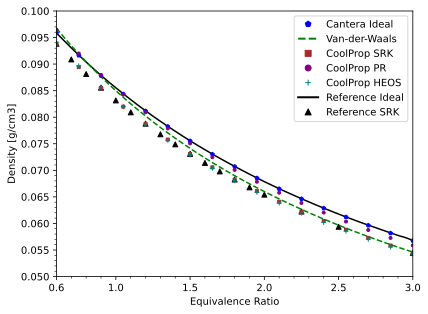

In [46]:
fig, ax1 = plt.subplots()
ax1.plot(rhoCase1['phi'], rhoCase1['rho'], color='black', linestyle='-', label='$Ideal Reference$')
ax1.plot(rhoCase2['phi'], rhoCase2['rho'], color='black', linestyle=' ', markersize=5, marker='^', label='$SRK Reference$')
ax1.plot(phi,rho_VdW, 'g--', label='$VdW rho')
ax1.plot(phi,rho_ct, ' ', color='b', marker='p', markersize=4, markevery=3, label='$Cantera Ideal$')
ax1.plot(phi,rho_SRK, ' ', color='brown', marker='s', markersize=3, markevery=3, label='$SRK$')
ax1.plot(phi,rho_PR, ' ', color='purple', marker='o', markersize=3, markevery=3, label='$PR$')
ax1.plot(phi,rho_HEOS, ' ', color='teal', marker='+', markersize=5, markevery=3, label='$HEOS$')
ax1.set_xlabel('Equivalence Ratio')
ax1.set_ylabel('Density [g/cm3]')
ax1.set_xlim(0.6, 3)
ax1.set_ylim(0.05, 0.1)
ax1.set_xticks([0.6, 1, 1.5, 2, 2.5, 3])
ax1.set_yticks([0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1])
ax1.minorticks_on()
custom_legend_lines = [
    Line2D([0], [0], color='blue', lw=2, linestyle=' ', marker='p', label='Cantera Ideal'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Van-der-Waals'),
    Line2D([0], [0], color='brown', lw=2, linestyle=' ', marker='s', label='CoolProp SRK'),
    Line2D([0], [0], color='purple', lw=2, linestyle=' ', marker='o', label='CoolProp PR'),
    Line2D([0], [0], color='teal', lw=2, linestyle=' ', marker='+', label='CoolProp HEOS'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Reference Ideal'),
    Line2D([0], [0], color='black', lw=2, linestyle=' ', marker='^', label='Reference SRK')
]
ax1.legend(handles=custom_legend_lines, loc='upper right')
plt.savefig("Graphs/rho H2-Air at 100atm.svg")
plt.show()

Canteras Ideal Prediction is spot on with reference. \
Van der Waals Overpredicts at low to moderate phis, and only apporaches reference SRK at high phis. \
CoolProp SRK and HEOS are very close to Reference. HEOS is slightly off, it overpredicts at low phis, and underpredicts at high phis. \
CoolProp PR consistently overpredicts compared to Reference (Not good, should be similar to other Cubics).

Overall, good results! There are some per-model disagreements, but no fundamental issues!